In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    kernel_size = 64
    filter_size = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5344 - acc: 0.3449
Epoch 00001: val_loss improved from inf to 1.80659, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_1_conv_checkpoint/001-1.8066.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.5342 - acc: 0.3450 - val_loss: 1.8066 - val_acc: 0.4363
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1939 - acc: 0.6544
Epoch 00002: val_loss did not improve from 1.80659
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.1939 - acc: 0.6544 - val_loss: 2.0064 - val_acc: 0.4542
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8410 - acc: 0.7610
Epoch 00003: val_loss did not improve from 1.80659
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.8409 - acc: 0.7611 - val_loss: 2.05

36800/36805 [============================>.] - ETA: 0s - loss: 0.1778 - acc: 0.9688
Epoch 00029: val_loss did not improve from 1.80659
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1778 - acc: 0.9688 - val_loss: 5.3205 - val_acc: 0.4454
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2560 - acc: 0.9581
Epoch 00030: val_loss did not improve from 1.80659
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2560 - acc: 0.9581 - val_loss: 5.1587 - val_acc: 0.4654
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2439 - acc: 0.9589
Epoch 00031: val_loss did not improve from 1.80659
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2438 - acc: 0.9589 - val_loss: 5.3810 - val_acc: 0.4591
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2231 - acc: 0.9621
Epoch 00032: val_loss did not improve from 1.80659
36805/36805 [========================

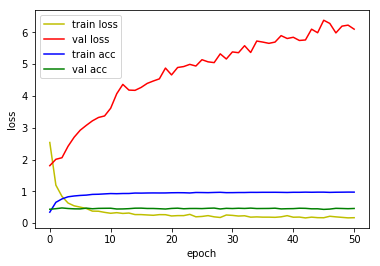

4815/4815 [==============================] - 2s 512us/sample - loss: 1.8823 - acc: 0.3907
Loss: 1.8822607367457136 Accuracy: 0.3906542

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5889 - acc: 0.3103
Epoch 00001: val_loss improved from inf to 3.40631, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_2_conv_checkpoint/001-3.4063.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 3.5888 - acc: 0.3103 - val_loss: 3.4063 - val_acc: 0.2991
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6419 - acc: 0.5039
Epoch 00002: val_loss improved from 3.40631 to 2.54833, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_2_conv_checkpoint/002-2.5483.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 2.6419 - acc: 0.5039 - val_loss: 2.5483 - val_acc: 0.5274
Epoch 3/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9692
Epoch 00028: val_loss did not improve from 2.01717
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.1097 - acc: 0.9692 - val_loss: 2.5039 - val_acc: 0.6224
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1335 - acc: 0.9621
Epoch 00029: val_loss did not improve from 2.01717
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.1335 - acc: 0.9621 - val_loss: 2.7127 - val_acc: 0.6117
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1105 - acc: 0.9702
Epoch 00030: val_loss did not improve from 2.01717
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.1105 - acc: 0.9702 - val_loss: 2.4977 - val_acc: 0.6334
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9725
Epoch 00031: val_loss did not improve from 2.01717
36805/36805 [=====================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9873
Epoch 00058: val_loss did not improve from 2.01717
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.0542 - acc: 0.9873 - val_loss: 2.5175 - val_acc: 0.6564
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9906
Epoch 00059: val_loss did not improve from 2.01717
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.0438 - acc: 0.9906 - val_loss: 2.7313 - val_acc: 0.6306
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9875
Epoch 00060: val_loss did not improve from 2.01717
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.0552 - acc: 0.9875 - val_loss: 2.6527 - val_acc: 0.6401
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9826
Epoch 00061: val_loss did not improve from 2.01717
36805/36805 [========

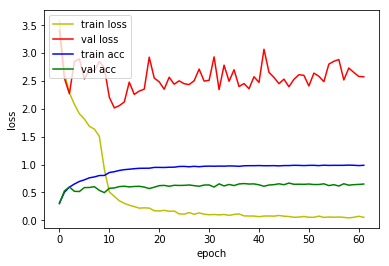

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.1421 - acc: 0.5566
Loss: 2.142140926329394 Accuracy: 0.55659395

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1844 - acc: 0.3616
Epoch 00001: val_loss improved from inf to 1.83084, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_3_conv_checkpoint/001-1.8308.hdf5
36805/36805 [==============================] - 206s 6ms/sample - loss: 2.1846 - acc: 0.3617 - val_loss: 1.8308 - val_acc: 0.4167
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3555 - acc: 0.5821
Epoch 00002: val_loss improved from 1.83084 to 1.23952, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_3_conv_checkpoint/002-1.2395.hdf5
36805/36805 [==============================] - 202s 5ms/sample - loss: 1.3556 - acc: 0.5821 - val_loss: 1.2395 - val_acc: 0.6040
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1041 - acc: 0.9681
Epoch 00029: val_loss did not improve from 0.84745
36805/36805 [==============================] - 202s 5ms/sample - loss: 0.1041 - acc: 0.9681 - val_loss: 1.1350 - val_acc: 0.7936
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9670
Epoch 00030: val_loss did not improve from 0.84745
36805/36805 [==============================] - 202s 5ms/sample - loss: 0.1037 - acc: 0.9670 - val_loss: 1.1561 - val_acc: 0.7927
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9699
Epoch 00031: val_loss did not improve from 0.84745
36805/36805 [==============================] - 202s 5ms/sample - loss: 0.1008 - acc: 0.9699 - val_loss: 1.6398 - val_acc: 0.7277
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1036 - acc: 0.9669
Epoch 00032: val_loss did not improve from 0.84745
36805/36805 [========

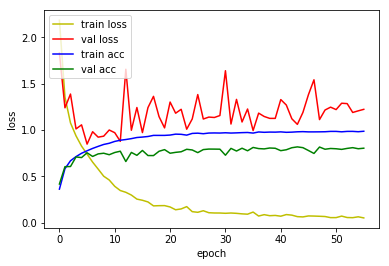

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9862 - acc: 0.7117
Loss: 0.98616148430239 Accuracy: 0.7117342

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0423 - acc: 0.3760
Epoch 00001: val_loss improved from inf to 1.67544, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_4_conv_checkpoint/001-1.6754.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 2.0422 - acc: 0.3760 - val_loss: 1.6754 - val_acc: 0.4633
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2073 - acc: 0.6219
Epoch 00002: val_loss improved from 1.67544 to 0.99712, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_4_conv_checkpoint/002-0.9971.hdf5
36805/36805 [==============================] - 210s 6ms/sample - loss: 1.2073 - acc: 0.6219 - val_loss: 0.9971 - val_acc: 0.6958
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1675 - acc: 0.9465
Epoch 00028: val_loss did not improve from 0.50468
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.1676 - acc: 0.9464 - val_loss: 0.7336 - val_acc: 0.8376
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1544 - acc: 0.9483
Epoch 00029: val_loss improved from 0.50468 to 0.49733, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_4_conv_checkpoint/029-0.4973.hdf5
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.1544 - acc: 0.9483 - val_loss: 0.4973 - val_acc: 0.8919
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1492 - acc: 0.9512
Epoch 00030: val_loss did not improve from 0.49733
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.1492 - acc: 0.9512 - val_loss: 0.6223 - val_acc: 0.8649
Epoch 31/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0722 - acc: 0.9769
Epoch 00057: val_loss did not improve from 0.49733
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0722 - acc: 0.9769 - val_loss: 0.8519 - val_acc: 0.8491
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9781
Epoch 00058: val_loss did not improve from 0.49733
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0688 - acc: 0.9781 - val_loss: 0.6606 - val_acc: 0.8849
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0673 - acc: 0.9780
Epoch 00059: val_loss did not improve from 0.49733
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0673 - acc: 0.9780 - val_loss: 0.8110 - val_acc: 0.8553
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9774
Epoch 00060: val_loss did not improve from 0.49733
36805/36805 [=====================

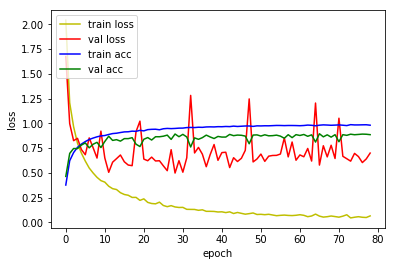

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5687 - acc: 0.8656
Loss: 0.5686791763622565 Accuracy: 0.86562824

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9975 - acc: 0.3943
Epoch 00001: val_loss improved from inf to 1.83088, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_5_conv_checkpoint/001-1.8309.hdf5
36805/36805 [==============================] - 221s 6ms/sample - loss: 1.9975 - acc: 0.3942 - val_loss: 1.8309 - val_acc: 0.4354
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2218 - acc: 0.6184
Epoch 00002: val_loss improved from 1.83088 to 1.14771, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_5_conv_checkpoint/002-1.1477.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 1.2219 - acc: 0.6183 - val_loss: 1.1477 - val_acc: 0.6564
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1419 - acc: 0.9540
Epoch 00027: val_loss improved from 0.40825 to 0.39379, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_5_conv_checkpoint/027-0.3938.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.1420 - acc: 0.9540 - val_loss: 0.3938 - val_acc: 0.9092
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1577 - acc: 0.9467
Epoch 00028: val_loss did not improve from 0.39379
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.1579 - acc: 0.9466 - val_loss: 0.4665 - val_acc: 0.8919
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1406 - acc: 0.9547
Epoch 00029: val_loss did not improve from 0.39379
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.1406 - acc: 0.9547 - val_loss: 0.4198 - val_acc: 0.8975
Epoch 30/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9812
Epoch 00056: val_loss did not improve from 0.39379
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0560 - acc: 0.9811 - val_loss: 0.5316 - val_acc: 0.8959
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9789
Epoch 00057: val_loss did not improve from 0.39379
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0665 - acc: 0.9789 - val_loss: 0.6750 - val_acc: 0.8593
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0504 - acc: 0.9838
Epoch 00058: val_loss did not improve from 0.39379
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0504 - acc: 0.9838 - val_loss: 0.4992 - val_acc: 0.8998
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9817
Epoch 00059: val_loss did not improve from 0.39379
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9883
Epoch 00085: val_loss did not improve from 0.36958
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0363 - acc: 0.9883 - val_loss: 0.4586 - val_acc: 0.9234
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9883
Epoch 00086: val_loss did not improve from 0.36958
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0382 - acc: 0.9883 - val_loss: 0.5477 - val_acc: 0.9068
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9883
Epoch 00087: val_loss did not improve from 0.36958
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0368 - acc: 0.9883 - val_loss: 0.5430 - val_acc: 0.9068
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9882
Epoch 00088: val_loss did not improve from 0.36958
36805/36805 [========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9921
Epoch 00115: val_loss did not improve from 0.36958
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0257 - acc: 0.9921 - val_loss: 0.4649 - val_acc: 0.9231
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9923
Epoch 00116: val_loss did not improve from 0.36958
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0249 - acc: 0.9922 - val_loss: 0.4568 - val_acc: 0.9189
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9890
Epoch 00117: val_loss did not improve from 0.36958
36805/36805 [==============================] - 215s 6ms/sample - loss: 0.0356 - acc: 0.9890 - val_loss: 0.4193 - val_acc: 0.9317
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9907
Epoch 00118: val_loss did not improve from 0.36958
36805/36805 [====

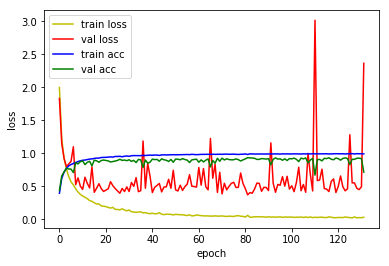

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4731 - acc: 0.9094
Loss: 0.4730949756233863 Accuracy: 0.90944964

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2091 - acc: 0.3247
Epoch 00001: val_loss improved from inf to 1.65103, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_6_conv_checkpoint/001-1.6510.hdf5
36805/36805 [==============================] - 225s 6ms/sample - loss: 2.2090 - acc: 0.3247 - val_loss: 1.6510 - val_acc: 0.4789
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2965 - acc: 0.5862
Epoch 00002: val_loss improved from 1.65103 to 0.98329, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_6_conv_checkpoint/002-0.9833.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 1.2965 - acc: 0.5863 - val_loss: 0.9833 - val_acc: 0.7018
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.1400 - acc: 0.9558
Epoch 00026: val_loss did not improve from 0.27401
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.1400 - acc: 0.9558 - val_loss: 0.2777 - val_acc: 0.9317
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1347 - acc: 0.9567
Epoch 00027: val_loss improved from 0.27401 to 0.26942, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_6_conv_checkpoint/027-0.2694.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.1348 - acc: 0.9567 - val_loss: 0.2694 - val_acc: 0.9355
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1357 - acc: 0.9563
Epoch 00028: val_loss did not improve from 0.26942
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.1358 - acc: 0.9563 - val_loss: 0.3011 - val_acc: 0.9266
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9793
Epoch 00055: val_loss did not improve from 0.24382
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0607 - acc: 0.9793 - val_loss: 0.5438 - val_acc: 0.8924
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9811
Epoch 00056: val_loss did not improve from 0.24382
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0578 - acc: 0.9811 - val_loss: 0.3270 - val_acc: 0.9283
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9814
Epoch 00057: val_loss did not improve from 0.24382
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0593 - acc: 0.9813 - val_loss: 0.3813 - val_acc: 0.9108
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9802
Epoch 00058: val_loss did not improve from 0.24382
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9858
Epoch 00085: val_loss did not improve from 0.24382
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0425 - acc: 0.9858 - val_loss: 0.5061 - val_acc: 0.9099

1D_CNN_custom_kernel_192_DO_BN_6_conv Model


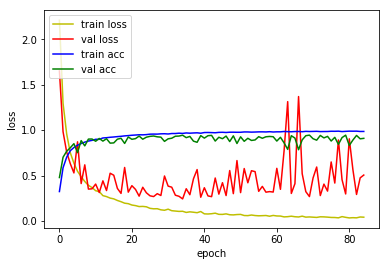

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3006 - acc: 0.9202
Loss: 0.3006058562334205 Accuracy: 0.9202492

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4963 - acc: 0.2515
Epoch 00001: val_loss improved from inf to 1.91124, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_7_conv_checkpoint/001-1.9112.hdf5
36805/36805 [==============================] - 230s 6ms/sample - loss: 2.4963 - acc: 0.2515 - val_loss: 1.9112 - val_acc: 0.3811
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5269 - acc: 0.5076
Epoch 00002: val_loss improved from 1.91124 to 1.15478, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_7_conv_checkpoint/002-1.1548.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 1.5270 - acc: 0.5076 - val_loss: 1.1548 - val_acc: 0.6380
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1362 - acc: 0.9550
Epoch 00026: val_loss did not improve from 0.20916
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.1362 - acc: 0.9550 - val_loss: 0.5443 - val_acc: 0.8565
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9594
Epoch 00027: val_loss improved from 0.20916 to 0.18264, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_7_conv_checkpoint/027-0.1826.hdf5
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.1279 - acc: 0.9594 - val_loss: 0.1826 - val_acc: 0.9546
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1318 - acc: 0.9579
Epoch 00028: val_loss did not improve from 0.18264
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.1318 - acc: 0.9579 - val_loss: 0.2670 - val_acc: 0.9290
Epoch 29/500
36800/36805 [============================>.] - ETA: 0

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0549 - acc: 0.9820
Epoch 00055: val_loss did not improve from 0.17970
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0549 - acc: 0.9820 - val_loss: 0.2154 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9822
Epoch 00056: val_loss did not improve from 0.17970
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0548 - acc: 0.9822 - val_loss: 0.4080 - val_acc: 0.9015
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9827
Epoch 00057: val_loss did not improve from 0.17970
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0533 - acc: 0.9827 - val_loss: 2.1289 - val_acc: 0.7088
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9837
Epoch 00058: val_loss did not improve from 0.17970
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9879
Epoch 00084: val_loss did not improve from 0.17364
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0365 - acc: 0.9879 - val_loss: 0.1857 - val_acc: 0.9590
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9911
Epoch 00085: val_loss did not improve from 0.17364
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0274 - acc: 0.9910 - val_loss: 0.3022 - val_acc: 0.9329
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9835
Epoch 00086: val_loss did not improve from 0.17364
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0504 - acc: 0.9835 - val_loss: 0.4995 - val_acc: 0.8954
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9894
Epoch 00087: val_loss did not improve from 0.17364
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9952
Epoch 00113: val_loss did not improve from 0.16406
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0155 - acc: 0.9952 - val_loss: 0.1934 - val_acc: 0.9571
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9945
Epoch 00114: val_loss did not improve from 0.16406
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0177 - acc: 0.9945 - val_loss: 0.2117 - val_acc: 0.9557
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9944
Epoch 00115: val_loss did not improve from 0.16406
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0180 - acc: 0.9943 - val_loss: 0.1864 - val_acc: 0.9611
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9917
Epoch 00116: val_loss did not improve from 0.16406
36805/36805 [==================

Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9953
Epoch 00143: val_loss did not improve from 0.16406
36805/36805 [==============================] - 219s 6ms/sample - loss: 0.0151 - acc: 0.9953 - val_loss: 0.3541 - val_acc: 0.9313
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9948
Epoch 00144: val_loss did not improve from 0.16406
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0159 - acc: 0.9948 - val_loss: 0.2624 - val_acc: 0.9509
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9961
Epoch 00145: val_loss did not improve from 0.16406
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0125 - acc: 0.9961 - val_loss: 0.2015 - val_acc: 0.9611
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9931
Epoch 00146: val_loss did not improve from 0.16406
36805/36805 [====

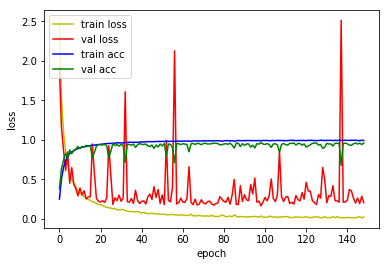

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2022 - acc: 0.9524
Loss: 0.20219213401169545 Accuracy: 0.95244026

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4420 - acc: 0.2751
Epoch 00001: val_loss improved from inf to 1.62449, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_8_conv_checkpoint/001-1.6245.hdf5
36805/36805 [==============================] - 234s 6ms/sample - loss: 2.4420 - acc: 0.2751 - val_loss: 1.6245 - val_acc: 0.5146
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5122 - acc: 0.5144
Epoch 00002: val_loss improved from 1.62449 to 1.00303, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_8_conv_checkpoint/002-1.0030.hdf5
36805/36805 [==============================] - 220s 6ms/sample - loss: 1.5124 - acc: 0.5144 - val_loss: 1.0030 - val_acc: 0.6988
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1288 - acc: 0.9588
Epoch 00025: val_loss did not improve from 0.14544
36805/36805 [==============================] - 220s 6ms/sample - loss: 0.1288 - acc: 0.9588 - val_loss: 0.1921 - val_acc: 0.9413
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1142 - acc: 0.9650
Epoch 00026: val_loss improved from 0.14544 to 0.14435, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_8_conv_checkpoint/026-0.1444.hdf5
36805/36805 [==============================] - 220s 6ms/sample - loss: 0.1142 - acc: 0.9650 - val_loss: 0.1444 - val_acc: 0.9592
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9658
Epoch 00027: val_loss improved from 0.14435 to 0.13530, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_8_conv_checkpoint/027-0.1353.hdf5
36805/36805 [==============================] - 221s 6ms/sample - loss: 0.1068 - acc: 0.9658 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9856
Epoch 00054: val_loss did not improve from 0.13506
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0459 - acc: 0.9856 - val_loss: 0.1673 - val_acc: 0.9529
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9881
Epoch 00055: val_loss did not improve from 0.13506
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0389 - acc: 0.9881 - val_loss: 0.1667 - val_acc: 0.9560
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9864
Epoch 00056: val_loss did not improve from 0.13506
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0452 - acc: 0.9864 - val_loss: 0.1559 - val_acc: 0.9585
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9888
Epoch 00057: val_loss did not improve from 0.13506
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9939
Epoch 00084: val_loss did not improve from 0.13506
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0200 - acc: 0.9939 - val_loss: 0.2362 - val_acc: 0.9478
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9924
Epoch 00085: val_loss did not improve from 0.13506
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0255 - acc: 0.9924 - val_loss: 0.1714 - val_acc: 0.9588
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9931
Epoch 00086: val_loss did not improve from 0.13506
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0212 - acc: 0.9931 - val_loss: 0.1645 - val_acc: 0.9632
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9937
Epoch 00087: val_loss did not improve from 0.13506
36805/36805 [========

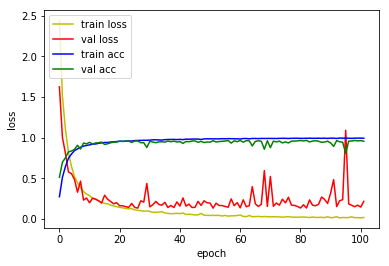

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1747 - acc: 0.9535
Loss: 0.17465961022633258 Accuracy: 0.9534787

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1932 - acc: 0.3682
Epoch 00001: val_loss improved from inf to 1.21442, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_9_conv_checkpoint/001-1.2144.hdf5
36805/36805 [==============================] - 236s 6ms/sample - loss: 2.1933 - acc: 0.3682 - val_loss: 1.2144 - val_acc: 0.6105
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1202 - acc: 0.6475
Epoch 00002: val_loss improved from 1.21442 to 0.85236, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_9_conv_checkpoint/002-0.8524.hdf5
36805/36805 [==============================] - 216s 6ms/sample - loss: 1.1203 - acc: 0.6475 - val_loss: 0.8524 - val_acc: 0.7333
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0775 - acc: 0.9758
Epoch 00026: val_loss did not improve from 0.12162
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0775 - acc: 0.9757 - val_loss: 0.1517 - val_acc: 0.9567
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0755 - acc: 0.9765
Epoch 00027: val_loss did not improve from 0.12162
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0755 - acc: 0.9765 - val_loss: 0.1894 - val_acc: 0.9457
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0694 - acc: 0.9783
Epoch 00028: val_loss improved from 0.12162 to 0.11698, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_9_conv_checkpoint/028-0.1170.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0694 - acc: 0.9783 - val_loss: 0.1170 - val_acc: 0.9634
Epoch 29/500
36800/36805 [============================>.] - ETA: 0

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9923
Epoch 00055: val_loss did not improve from 0.11243
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0244 - acc: 0.9923 - val_loss: 0.1289 - val_acc: 0.9658
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9928
Epoch 00056: val_loss did not improve from 0.11243
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0242 - acc: 0.9928 - val_loss: 0.1313 - val_acc: 0.9644
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9940
Epoch 00057: val_loss did not improve from 0.11243
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0204 - acc: 0.9940 - val_loss: 0.1636 - val_acc: 0.9627
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9908
Epoch 00058: val_loss did not improve from 0.11243
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9961
Epoch 00085: val_loss did not improve from 0.11243
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0123 - acc: 0.9961 - val_loss: 0.1677 - val_acc: 0.9653
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9965
Epoch 00086: val_loss did not improve from 0.11243
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0118 - acc: 0.9965 - val_loss: 0.1470 - val_acc: 0.9634
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9950
Epoch 00087: val_loss improved from 0.11243 to 0.10146, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_BN_9_conv_checkpoint/087-0.1015.hdf5
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.0169 - acc: 0.9950 - val_loss: 0.1015 - val_acc: 0.9755
Epoch 88/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9976
Epoch 00114: val_loss did not improve from 0.10146
36805/36805 [==============================] - 220s 6ms/sample - loss: 0.0077 - acc: 0.9976 - val_loss: 0.1576 - val_acc: 0.9669
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9977
Epoch 00115: val_loss did not improve from 0.10146
36805/36805 [==============================] - 221s 6ms/sample - loss: 0.0077 - acc: 0.9977 - val_loss: 0.1463 - val_acc: 0.9695
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9977
Epoch 00116: val_loss did not improve from 0.10146
36805/36805 [==============================] - 221s 6ms/sample - loss: 0.0084 - acc: 0.9977 - val_loss: 0.1743 - val_acc: 0.9639
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9979
Epoch 00117: val_loss did not improve from 0.10146
36805/36805 [==================

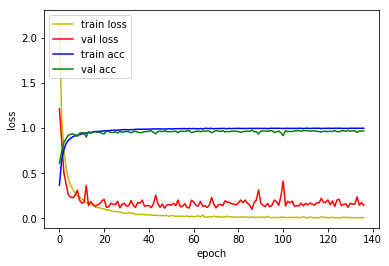

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1531 - acc: 0.9641
Loss: 0.1531310552408264 Accuracy: 0.9640706



In [10]:
base = '1D_CNN_custom_kernel_192_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,496
Non-trainable params: 128
_________________

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.5687 - acc: 0.8656
Loss: 0.5686791763622565 Accuracy: 0.86562824

1D_CNN_custom_kernel_192_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2022 - acc: 0.9524
Loss: 0.20219213401169545 Accuracy: 0.95244026

1D_CNN_custom_kernel_192_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)  

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.1531 - acc: 0.9641
Loss: 0.1531310552408264 Accuracy: 0.9640706


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,496
Non-trainable params: 128
_________________

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.8243 - acc: 0.8623
Loss: 0.8242827140901196 Accuracy: 0.8623053

1D_CNN_custom_kernel_192_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.2601 - acc: 0.9464
Loss: 0.26006958857333423 Accuracy: 0.94641745

1D_CNN_custom_kernel_192_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)  

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2167 - acc: 0.9570
Loss: 0.2167260921670236 Accuracy: 0.9570094
